<a class="anchor" id="toc"></a>
# Table of Contents

1. [Install libraries](#install-libraries)
1. [Import libraries](#import-libraries)
1. [Load and clean dataset](#load-and-clean-dataset)
1. [Split data, Vectorize (TF-IDF) and Binarize](#split-data-vectorize-tf-idf-and-binarize)
1. [Implement NSA](#implement-nsa)
1. [Validation](#validation)
1. [Evaluate](#evaluate)

<a class="anchor" id="install-libraries"></a>
# Install libraries

In [2]:
# install requirements from requirements.txt
%pip install -r ../requirements.txt

<a class="anchor" id="import-libraries"></a>
# Import libraries

In [2]:
# Basic data handling
import pandas as pd
import numpy as np
import re

# Machine learning & text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, f1_score, auc,
    precision_score, recall_score, accuracy_score
)

# Sparse matrix operations
import scipy.sparse as sp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Utility
from dataclasses import dataclass
import pickle
import time


<a class="anchor" id="load-and-clean-dataset"></a>
# Load and clean dataset

Here we load the dataset and clean it by :
- converting to lowercase
- removing html tags
- remove whitespace
- replace URLs and emails with placeholders

The cleaned text is stored in a new column 'cleaned_message'and the labels are encoded as 0 for 'ham' and 1 for 'spam'.




In [20]:
# Load dataset
df = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['label', 'message'])
#df.head()

# data cleaning function
'''we will remove html tags, urls, punctuation, numbers, emails, and extra whitespace.
but we will keep the option to not remove urls and emails if needed in future because they might be relevant for spam detection.'''

def clean_text(text: str) -> str:
    if pd.isna(text) or not isinstance(text, str): # check for NaN or non-string
        return ""

    text = text.lower()

    # replace URLs
    text = re.sub(r'http\S+|www\S+', ' <URL> ', text)

    # replace emails
    text = re.sub(r'\S+@\S+', ' <EMAIL> ', text)

    # remove html tags (very rare in SMS)
    text = re.sub(r'<[^>]+>', ' ', text)

    # keep numbers, letters, placeholders
    text = re.sub(r'[^a-z0-9<> ]+', ' ', text)

    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# apply cleaning

df['cleaned_message'] = df['message'].apply(clean_text)
# encode labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# compare original and cleaned messages to see the effect of cleaning
df[['message', 'cleaned_message']].head(10)




,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it s been 3 week s n...
6,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me t...
7,As per your request 'Melle Melle (Oru Minnamin...,as per your request melle melle oru minnaminun...
8,WINNER!! As a valued network customer you have...,winner as a valued network customer you have b...
9,Had your mobile 11 months or more? U R entitle...,had your mobile 11 months or more u r entitled...


The cleaning function is working as we want and we advance with this implementation.

<a class="anchor" id="split-data-vectorize-tf-idf-and-binarize"></a>
# Split data, Vectorize (TF-IDF) and Binarize
## Split data
We want to split the data into:
- training set (60% of ham because the model is trained only on ham): used for training the NSA model
- validation set (20% of the rest of the data): used for tuning hyperparameters
- test set (20% of the rest of the data): used for evaluating the final model

In [21]:
# Separete ham and spam
ham = df[df['label'] == 0]['cleaned_message']
spam = df[df['label'] == 1]['cleaned_message']

print(f"Total ham messages: {len(ham)}")
print(f"Total spam messages: {len(spam)}")

# split function
def create_train_val_test_splits(df: pd.DataFrame, 
                                   text_col: str,
                                   train_ratio: float = 0.6,
                                   random_state: int = 42):
    """
    Split ham/spam data into train/val/test sets.
    
    Train: 60% of ham only
    Val: 20% ham + 50% spam
    Test: 20% ham + 50% spam
    """
    ham = df[df['label'] == 0][text_col]
    spam = df[df['label'] == 1][text_col]
    
    # Split ham
    ham_train, ham_temp = train_test_split(ham, train_size=train_ratio, 
                                            random_state=random_state)
    ham_val, ham_test = train_test_split(ham_temp, test_size=0.5, 
                                          random_state=random_state)
    
    # Split spam
    spam_val, spam_test = train_test_split(spam, test_size=0.5, 
                                            random_state=random_state)
    
    return {
        'ham_train': ham_train, 'ham_val': ham_val, 'ham_test': ham_test,
        'spam_val': spam_val, 'spam_test': spam_test
    }
splits = create_train_val_test_splits(df, text_col='cleaned_message')

# table showing the distribution of messages 
table = [
    ["Train", len(splits['ham_train']), 0],
    ["Validation", len(splits['ham_val']), len(splits['spam_val'])],
    ["Test", len(splits['ham_test']), len(splits['spam_test'])],
    ["Total", len(splits['ham_train']) + len(splits['ham_val']) + len(splits['ham_test']), 
    len(splits['spam_val']) + len(splits['spam_test'])]
]
print(tabulate(table, headers=["Set", "Ham", "Spam"], tablefmt="github"))

Total ham messages: 4825
Total spam messages: 747
| Set        |   Ham |   Spam |
|------------|-------|--------|
| Train      |  2895 |      0 |
| Validation |   965 |    373 |
| Test       |   965 |    374 |
| Total      |  4825 |    747 |


## Vectorize (TF-IDF)
To vectorize the message we chose to use TfidfVectorizer which is a scikit-learn tool that turns a pile of text into numbers our model will be able to use. The vectorizer can be customized with different parameters to fit our needs and the parameters we chose to change are:
- `max_df=0.95`: This parameter ignores terms that appear in more than 95% of the documents, which helps to remove common words that may not be informative.
- `min_df=2`: This parameter ignores terms that appear in fewer than 2 documents, which helps to eliminate rare words that may not contribute significantly to the model.
- `ngram_range=(1, 2)`: This parameter considers both single words (unigrams) and pairs of consecutive words (bigrams), which can capture more context and improve the model's understanding of the text.
- `sublinear_tf=True`: This parameter applies sublinear term frequency scaling, which can help to reduce the impact of very frequent terms and improve the model's performance.

This is the vectorizer we will use for now but we might experiment with other vectorizers later if we find it necessary.


In [22]:

# Vectorizer for normal cleaned messages
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    sublinear_tf=True
)

Xh_train = vectorizer.fit_transform(splits['ham_train'])
Xh_val   = vectorizer.transform(splits['ham_val'])
Xh_test   = vectorizer.transform(splits['ham_test'])
Xs_val   = vectorizer.transform(splits['spam_val'])
Xs_test   = vectorizer.transform(splits['spam_test'])
print("Vocabulary (plain):", len(vectorizer.vocabulary_))
print("Train matrix shape (plain):", Xh_train.shape)



Vocabulary (plain): 7012
Train matrix shape (plain): (2895, 7012)


from 2895 spam messages we got 7012 unique tokens after vectorization.

## Binarize
We change the TF-IDF values to binary values (0 and 1) based on a threshold tau. If the TF-IDF value is greater than tau, it is set to 1; otherwise, it is set to 0. Binarization is necessary for the NSA model because it relies on binary feature representations to detect anomalies effectively.

In [23]:
# binarization function
def binarize_matrix(X: sp.csr_matrix, tau: float = 0.01) -> sp.csr_matrix:
    X_bin = (X >= tau).astype(np.uint8)
    density = X_bin.nnz / (X_bin.shape[0] * X_bin.shape[1])
    print(f"density={density:.6f}")
    return X_bin

# apply binarization
tau = 0.01
Xh_train_bin = binarize_matrix(Xh_train, tau)
Xh_val_bin   = binarize_matrix(Xh_val, tau)
Xh_test_bin  = binarize_matrix(Xh_test, tau)
Xs_val_bin   = binarize_matrix(Xs_val, tau)
Xs_test_bin  = binarize_matrix(Xs_test, tau)
# sanity check
print("Binarized train matrix shape (url_email):", Xh_train_bin.shape)

density=0.002408
density=0.001945
density=0.001985
density=0.002182
density=0.002178
Binarized train matrix shape (url_email): (2895, 7012)


the shapes match our TF-IDF shapes so that is good. the density is quit low but that is something we will be tuning during validation if it did not work out.

<a class="anchor" id="implement-nsa"></a>
# NSA implementation

This NSA builds binary detectors in three steps:
- Compute antiprofile sampling weights from ham feature frequencies so rare tokens are favoured.
- Repeatedly sample `k` active indices, draw a radius in `[r_min, r_max]`, and keep only detectors whose overlaps with ham stay below that radius.
- Stack the accepted detectors into a sparse matrix so predictions can batch-check overlap counts against the `k_hits` threshold (with optional score outputs and pickle-based save/load).

In [26]:
@dataclass
class Detector:
    idx: np.ndarray   # active bit positions
    radius: int       # required overlap threshold


class VDetectorNSA_Binary:
    """
    Optimized Binary Negative Selection Algorithm (NSA) with:
      • antiprofile sampling
      • sparse-only overlap calculations
      • pre-built detector matrix for prediction/coverage
      • consistent memory behavior
    """

    def __init__(self,
                 k: int,
                 r_min: int, r_max: int,
                 max_detectors: int,
                 max_tries: int,
                 batch_size: int,
                 sampling: str = "antiprofile",
                 alpha: float = 2.0,
                 random_state: int = 42):

        self.k = k
        self.r_min = r_min
        self.r_max = r_max
        self.max_detectors = max_detectors
        self.max_tries = max_tries
        self.batch_size = batch_size
        self.sampling = sampling
        self.alpha = alpha
        self.random_state = random_state

        self.dim = None
        self.detectors: list[Detector] = []
        self.p_detect = None

        # Cached after training
        self.det_matrix = None
        self.r_array = None

        np.random.seed(self.random_state)

    # --------------------------------------------------------------
    # antiprofile probability construction
    # --------------------------------------------------------------
    def _build_antiprofile_probs(self, X_ham_train: sp.csr_matrix):
        assert sp.issparse(X_ham_train)

        p_ham = (X_ham_train.sum(axis=0) / X_ham_train.shape[0]).A1
        p = (1.0 - p_ham + 1e-6) ** self.alpha
        p = np.clip(p, 1e-12, None)
        self.p_detect = p / p.sum()

    # --------------------------------------------------------------
    # random sparse detector generator
    # --------------------------------------------------------------
    def _sample_indices(self) -> np.ndarray:
        size = min(self.k, self.dim)

        if self.sampling == "antiprofile" and self.p_detect is not None:
            idx = np.random.choice(self.dim, size=size,
                                   replace=False, p=self.p_detect)
        else:
            idx = np.random.choice(self.dim, size=size, replace=False)

        return np.sort(idx)

    def _vec_from_idx(self, idx: np.ndarray) -> sp.csr_matrix:
        """Sparse row vector representing a detector."""
        data = np.ones(len(idx), dtype=np.uint8)
        rows = np.zeros(len(idx), dtype=np.int32)
        return sp.csr_matrix((data, (rows, idx)), shape=(1, self.dim))

    # --------------------------------------------------------------
    # efficient overlap calculation (NO dense conversion)
    # --------------------------------------------------------------
    def _max_overlap(self, X_ham: sp.csr_matrix, det_vec: sp.csr_matrix) -> int:
        max_ov = 0
        n = X_ham.shape[0]

        for s in range(0, n, self.batch_size):
            e = min(s + self.batch_size, n)
            overlaps = X_ham[s:e].dot(det_vec.T)  # stays sparse

            if overlaps.nnz > 0:
                batch_max = overlaps.data.max()
                if batch_max > max_ov:
                    max_ov = batch_max

            if max_ov >= self.r_max:
                break

        return max_ov

    # --------------------------------------------------------------
    # radius sampler
    # --------------------------------------------------------------
    def _sample_radius(self) -> int:
        if self.r_min == self.r_max:
            return self.r_min
        return np.random.randint(self.r_min, self.r_max + 1)

    # --------------------------------------------------------------
    # build detector matrix ONCE after training
    # --------------------------------------------------------------
    def _compile_detector_matrix(self):
        rows, cols, data, radii = [], [], [], []

        for i, det in enumerate(self.detectors):
            rows.extend([i] * len(det.idx))
            cols.extend(det.idx)
            data.extend([1] * len(det.idx))
            radii.append(det.radius)

        self.det_matrix = sp.csr_matrix(
            (data, (rows, cols)),
            shape=(len(self.detectors), self.dim)
        )
        self.r_array = np.array(radii)

    # --------------------------------------------------------------
    # MAIN: fit
    # --------------------------------------------------------------
    def fit(self, X_ham_train: sp.csr_matrix, return_runtime: bool = False):

        assert sp.issparse(X_ham_train)
        start = time.time()

        self.dim = X_ham_train.shape[1]
        self.detectors = []

        if self.sampling == "antiprofile":
            self._build_antiprofile_probs(X_ham_train)

        accepted = 0
        tries = 0

        while accepted < self.max_detectors and tries < self.max_tries:
            tries += 1

            idx = self._sample_indices()
            det_vec = self._vec_from_idx(idx)
            r = self._sample_radius()

            m_o = self._max_overlap(X_ham_train, det_vec)

            if m_o >= r:
                continue

            self.detectors.append(Detector(idx=idx, radius=r))
            accepted += 1

        runtime = time.time() - start
        print(f"Generated {accepted} detectors after {tries} tries in {runtime:.2f}s.")

        # Build detector matrix ONCE
        self._compile_detector_matrix()

        if return_runtime:
            return self, runtime
        return self

    # --------------------------------------------------------------
    # prediction
    # --------------------------------------------------------------
    def predict(self, X_bin: sp.csr_matrix, k_hits: int = 1, return_score: bool = False):
        assert self.det_matrix is not None, "Model not fitted."
        assert sp.issparse(X_bin)

        n = X_bin.shape[0]
        predictions = np.zeros(n, dtype=np.uint8)
        scores = np.zeros(n, dtype=np.int32) if return_score else None

        for s in range(0, n, self.batch_size):
            e = min(s + self.batch_size, n)

            overlaps = X_bin[s:e].dot(self.det_matrix.T)  # sparse
            overlaps = overlaps.toarray()                # convert only once

            hits = overlaps >= self.r_array

            if return_score:
                scores[s:e] = hits.sum(axis=1)

            if k_hits == 1:
                predictions[s:e] = hits.any(axis=1).astype(np.uint8)
            else:
                predictions[s:e] = (hits.sum(axis=1) >= k_hits).astype(np.uint8)

        return (predictions, scores) if return_score else predictions

    # --------------------------------------------------------------
    # coverage
    # --------------------------------------------------------------
    def detector_coverage_report(self, X, y, k_hits=1):
        """
        Returns:
        ham_cov: fraction of ham samples that fire ≥1 detector
        spam_cov: fraction of spam samples that fire ≥1 detector
        mean_hits_ham: avg detector hits on ham messages that fire at least once
        mean_hits_spam: avg detector hits on spam messages that fire at least once
        """
        assert self.det_matrix is not None
        assert sp.issparse(X)

        predictions, scores = self.predict(X, k_hits=k_hits, return_score=True)

        # masks
        ham_mask = (y == 0)
        spam_mask = (y == 1)

        # coverage
        ham_cov = (scores[ham_mask] > 0).mean()
        spam_cov = (scores[spam_mask] > 0).mean()

        # mean hits per covered sample
        mean_hits_ham = scores[ham_mask][scores[ham_mask] > 0].mean() if ham_cov > 0 else 0.0
        mean_hits_spam = scores[spam_mask][scores[spam_mask] > 0].mean() if spam_cov > 0 else 0.0

        return {
            "ham_coverage": ham_cov,
            "spam_coverage": spam_cov,
            "mean_hits_ham": float(mean_hits_ham),
            "mean_hits_spam": float(mean_hits_spam)
        }


    # --------------------------------------------------------------
    # save / load
    # --------------------------------------------------------------
    def save(self, filepath: str):
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)

    def load(self, filepath: str):
        with open(filepath, 'rb') as f:
            model = pickle.load(f)
        self.__dict__.update(model.__dict__)


<a class="anchor" id="validation"></a>
# Validation
We will validate the NSA model using the validation set and tune the following hyperparameters:
- `num_detectors`: Number of detectors to generate.
- `k`: Number of active features in each detector.
- `r_min` and `r_max`: Minimum and maximum radius for detector acceptance.
- `k_hits`: Minimum number of detector matches required to classify a message as spam.

if the model performance is bad we might consider changing the vectorization method or even the cleaning method.

## Run and Evaluate on validation set

In [27]:
nsa = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=3,
    max_detectors=2000,
    max_tries=50000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
)

nsa ,train_runtime = nsa.fit(Xh_train_bin, return_runtime=True)
print(f"Training runtime: {train_runtime:.2f} seconds")


Generated 2000 detectors after 5651 tries in 5.28s.
Training runtime: 5.28 seconds


In [29]:
# build eval set
X_eval = sp.vstack([Xh_val_bin, Xs_val_bin])
y_eval = np.hstack([
    np.zeros(Xh_val_bin.shape[0], dtype=np.uint8),
    np.ones(Xs_val_bin.shape[0], dtype=np.uint8)
])

pred_start = time.time()
y_pred, scores = nsa.predict(X_eval, k_hits=1, return_score=True)
prediction_runtime = time.time() - pred_start
print(f"Prediction runtime: {prediction_runtime:.2f} seconds")


Prediction runtime: 0.02 seconds


### Evaluation Metrics
To evaluate the model's performance, we will use the following metrics:
- `F1-score` : to evaluate the balance between precision and recall.
- `Precision`: to measure the accuracy of positive predictions.
- `Recall`: to measure the ability to find all positive instances.
- `Accuracy`: to measure the overall correctness of the model.
- `Confusion Matrix`: to visualize the performance of the classification model.
- `Precision-Recall Curve`: to illustrate the trade-off between precision and recall at different thresholds.
- `PR-AUC`: to summarize the overall performance of the model across all thresholds.
- `Detector Coverage`: to assess how well the detectors cover the feature space of ham messages.
- `Runtime`: to measure the time taken for training and prediction.

In [44]:
# ============================================================
#  CLASSIFICATION METRICS
# ============================================================
def print_classification_metrics(y_true, y_pred, target_names=("ham", "spam")):
    report = classification_report(
        y_true, y_pred, target_names=target_names, zero_division=0
    )
    print(report)
    return report



# ============================================================
#  CONFUSION MATRIX
# ============================================================
def plot_confusion_matrix_heatmap(y_true, y_pred, labels=("ham", "spam"), title="Confusion Matrix", ax=None):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=[f"True {l.title()}" for l in labels],
        columns=[f"Pred {l.title()}" for l in labels]
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))

    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    plt.tight_layout()

    return cm_df



# ============================================================
#  PRECISION–RECALL CURVE
# ============================================================
def plot_precision_recall_curve(y_true, scores, title="Precision–Recall Curve", ax=None, label=None, show_legend=True):
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)

    curve_label = f"{label} (AUC={pr_auc:.3f})" if label else f"PR AUC={pr_auc:.3f}"

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    ax.plot(recall, precision, linewidth=2, label=curve_label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.grid(True)

    if show_legend:
        ax.legend()

    return pr_auc



# ============================================================
#  KDE DETECTOR HIT DISTRIBUTION (WITH ZOOM + CLIPPING)
# ============================================================
def plot_detector_hits_kde(
    scores,
    y,
    ax,
    label,
    color_ham,
    color_spam,
    linestyle="-",
    max_hits=6   # <--- zoom range here
):

    # clip scores so KDE isn't ruined by long tails
    ham_scores = np.clip(scores[y == 0], 0, max_hits)
    spam_scores = np.clip(scores[y == 1], 0, max_hits)

    sns.kdeplot(
        ham_scores, ax=ax,
        color=color_ham, linestyle=linestyle,
        label=f"{label} Ham"
    )
    sns.kdeplot(
        spam_scores, ax=ax,
        color=color_spam, linestyle=linestyle,
        label=f"{label} Spam"
    )



# ============================================================
#  CREATE FIGURES WITH ZOOM
# ============================================================
def create_pr_figure():
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title("Precision–Recall Curve Comparison")
    ax.grid(True)
    return fig, ax


def create_kde_figure(max_hits=6):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title("Detector Hit Distribution (KDE Comparison)")
    ax.set_xlabel("Detector Hits")
    ax.set_ylabel("Density")
    ax.set_xlim(0, max_hits)   # <--- zoom
    ax.grid(True, alpha=0.3)
    return fig, ax



# ============================================================
#  MAIN EVALUATION WRAPPER
# ============================================================
def evaluate_model(
    y_true,
    y_pred,
    scores,
    *,
    pr_ax=None,
    kde_ax=None,
    pr_label=None,
    linestyle="-",
    kde_color_ham="blue",
    kde_color_spam="red",
    detector_coverage_report=None,
    train_runtime=None,
    prediction_runtime=None,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix",
    pr_title="Precision–Recall Curve",
    max_hits_kde=6
):

    print_classification_metrics(y_true, y_pred, target_names)

    plot_confusion_matrix_heatmap(
        y_true, y_pred, labels=target_names, title=cm_title
    )

    pr_auc = plot_precision_recall_curve(
        y_true, scores, title=pr_title, ax=pr_ax, label=pr_label
    )

    if kde_ax is not None:
        plot_detector_hits_kde(
            scores, y_true, kde_ax, pr_label,
            color_ham=kde_color_ham,
            color_spam=kde_color_spam,
            linestyle=linestyle,
            max_hits=max_hits_kde
        )

    metrics = {
        "precision": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        "recall": recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        "f1": f1_score(y_true, y_pred, pos_label=1),
        "accuracy": accuracy_score(y_true, y_pred),
        "pr_auc": pr_auc,
        "train_runtime": train_runtime,
        "prediction_runtime": prediction_runtime,
    }

    if detector_coverage_report:
        metrics.update({
            "ham_coverage": detector_coverage_report["ham_coverage"],
            "spam_coverage": detector_coverage_report["spam_coverage"],
            "mean_hits_spam": detector_coverage_report["mean_hits_spam"],
        })

    return metrics

The current NSA model fails to detect spam effectively and the metrics clearly show that the detectors is not interacting meanigfully with the data. There is extremely low detector coverage the histogram shows almost all messages receive 0 hits. This is likely due to the low density of the binarized data.

Therefore, we will switch to using character n-grams for vectorization instead of word n-grams to increase the density of the binarized data and improve detector coverage.

In [53]:
# make a char level TF-IDF vectorizer with ngram range (3, 5)
vectorizer_char = TfidfVectorizer(
    ngram_range=(3, 5),
    max_df=0.95,
    min_df=2,
    sublinear_tf=True,
    analyzer='char_wb'
)

Xh_train_char = vectorizer_char.fit_transform(splits['ham_train'])
Xh_val_char   = vectorizer_char.transform(splits['ham_val'])
Xh_test_char  = vectorizer_char.transform(splits['ham_test'])
Xs_val_char   = vectorizer_char.transform(splits['spam_val'])
Xs_test_char  = vectorizer_char.transform(splits['spam_test'])
print("Vocabulary (char-level):", len(vectorizer_char.vocabulary_))
print("Train matrix shape (char-level):", Xh_train_char.shape)

# apply binarization
tau = 0.01
Xh_train_char_bin = binarize_matrix(Xh_train_char, tau)
Xh_val_char_bin   = binarize_matrix(Xh_val_char, tau)   
Xh_test_char_bin  = binarize_matrix(Xh_test_char, tau)
Xs_val_char_bin   = binarize_matrix(Xs_val_char, tau)
Xs_test_char_bin  = binarize_matrix(Xs_test_char, tau)  
# sanity check
print("Binarized train matrix shape (char-level):", Xh_train_char_bin.shape)

nsa_char = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=3,
    max_detectors=2000,
    max_tries=50000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
)

nsa_char, train_runtime_char = nsa_char.fit(Xh_train_char_bin, return_runtime=True)
print(f"Training runtime (char-level): {train_runtime_char:.2f} seconds")


Vocabulary (char-level): 16688
Train matrix shape (char-level): (2895, 16688)
density=0.006373
density=0.005827
density=0.005964
density=0.009823
density=0.009660
Binarized train matrix shape (char-level): (2895, 16688)
Generated 2000 detectors after 12580 tries in 18.97s.
Training runtime (char-level): 18.97 seconds
Generated 2000 detectors after 12580 tries in 18.97s.
Training runtime (char-level): 18.97 seconds


Prediction runtime: 0.02 seconds
              precision    recall  f1-score   support

         ham       0.81      0.90      0.85       965
        spam       0.64      0.44      0.52       373

    accuracy                           0.77      1338
   macro avg       0.72      0.67      0.69      1338
weighted avg       0.76      0.77      0.76      1338



,precision,recall,f1,accuracy,pr_auc,train_runtime,prediction_runtime,ham_coverage,spam_coverage,mean_hits_spam
0,0.637066,0.442359,0.522152,0.77429,0.516271,71.281503,0.020756,0.097409,0.442359,1.454545


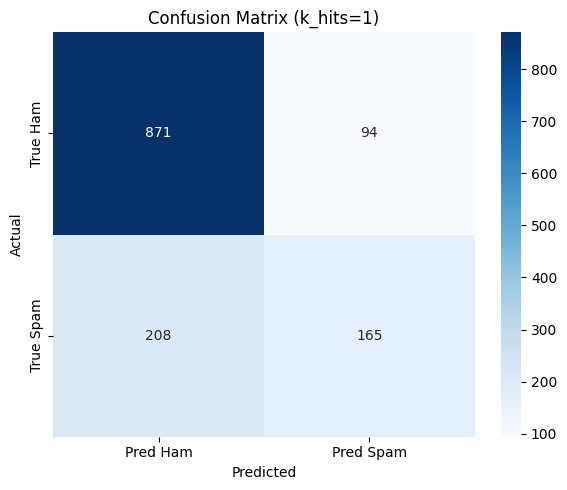

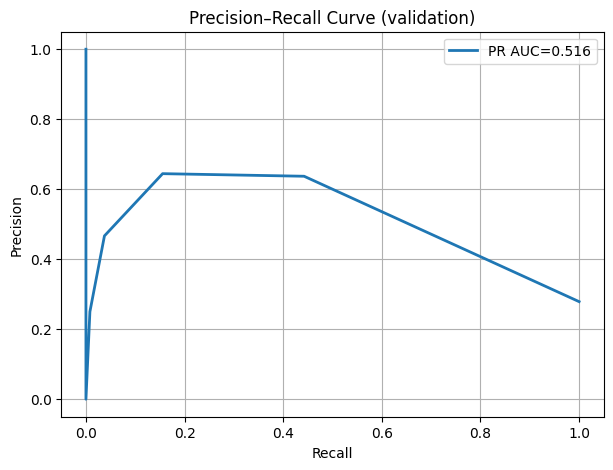

In [54]:
# build val eval set
# build eval set
X_eval = sp.vstack([Xh_val_char_bin, Xs_val_char_bin])
y_eval = np.hstack([
    np.zeros(Xh_val_char_bin.shape[0], dtype=np.uint8),
    np.ones(Xs_val_char_bin.shape[0], dtype=np.uint8)
])

pred_start = time.time()
y_pred, scores = nsa_char.predict(X_eval, k_hits=1, return_score=True)
prediction_runtime = time.time() - pred_start
print(f"Prediction runtime: {prediction_runtime:.2f} seconds")


coverage_report = nsa_char.detector_coverage_report(X_eval, y_eval, k_hits=1)

eval_results = evaluate_model(
    y_true=y_eval,
    y_pred=y_pred,
    scores=scores,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (k_hits=1)",
    pr_title="Precision–Recall Curve (validation)",
    detector_coverage_report=coverage_report,
    train_runtime=train_runtime,
    prediction_runtime=prediction_runtime
)

summary_table = pd.DataFrame([eval_results])
summary_table

Switching to character n-grams has improved the model's performance significantly. The detector coverage has increased, and the evaluation metrics show better detection of spam messages. The histogram indicates a more meaningful interaction between detectors and the data, suggesting that character-level features are more effective for this task. The confusion matrix and precision-recall curve further support the improved performance, indicating that the model is now better at distinguishing between ham and spam messages. 

Now we will try to tune the parameters for this to get the best possible version. From the Detector hit histogram we see that spam hits rarely exceed 1-3 hits. So i would maybe help to increase k in order to get more hits on spam messages.


=== Running NSA for k=20 ===
Generated 2000 detectors after 12580 tries in 48.23s.
              precision    recall  f1-score   support

         ham       0.81      0.90      0.85       965
        spam       0.64      0.44      0.52       373

    accuracy                           0.77      1338
   macro avg       0.72      0.67      0.69      1338
weighted avg       0.76      0.77      0.76      1338

Generated 2000 detectors after 12580 tries in 48.23s.
              precision    recall  f1-score   support

         ham       0.81      0.90      0.85       965
        spam       0.64      0.44      0.52       373

    accuracy                           0.77      1338
   macro avg       0.72      0.67      0.69      1338
weighted avg       0.76      0.77      0.76      1338


=== Running NSA for k=25 ===

=== Running NSA for k=25 ===
Generated 2000 detectors after 20984 tries in 70.24s.
              precision    recall  f1-score   support

         ham       0.84      0.86      

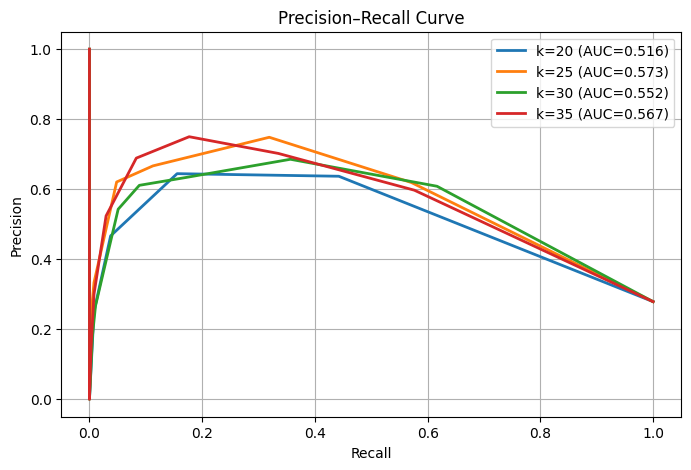

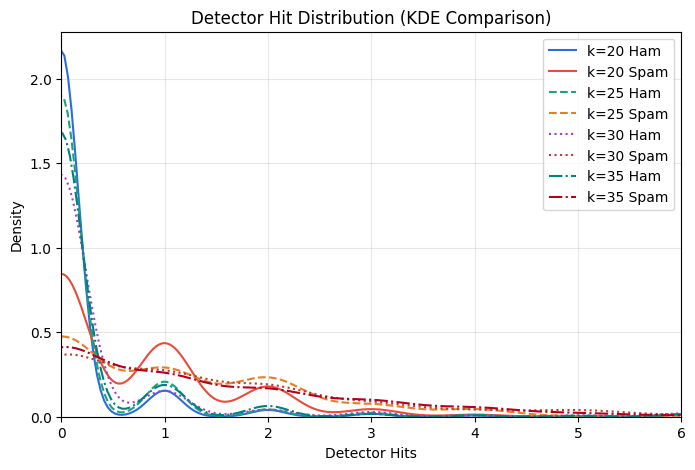

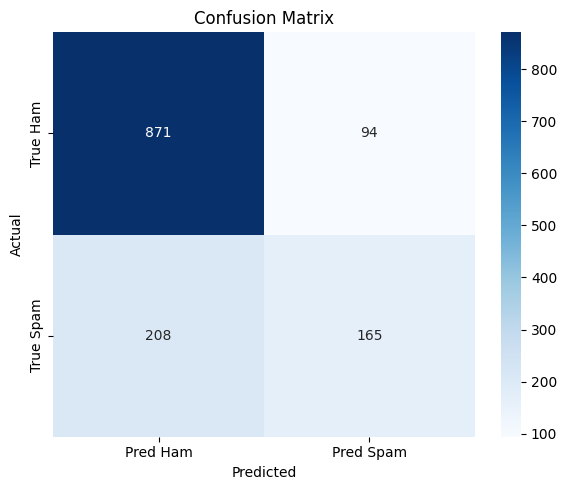

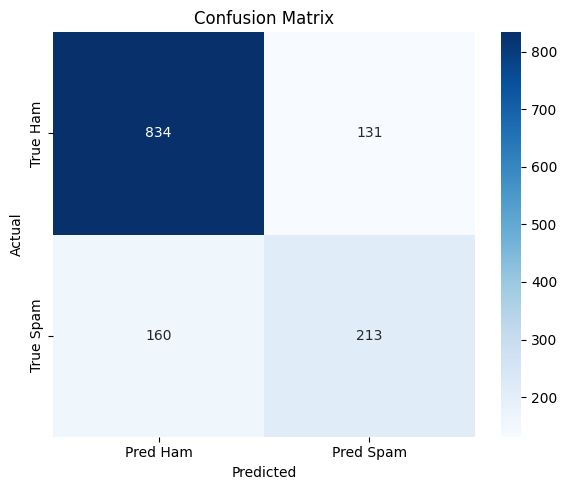

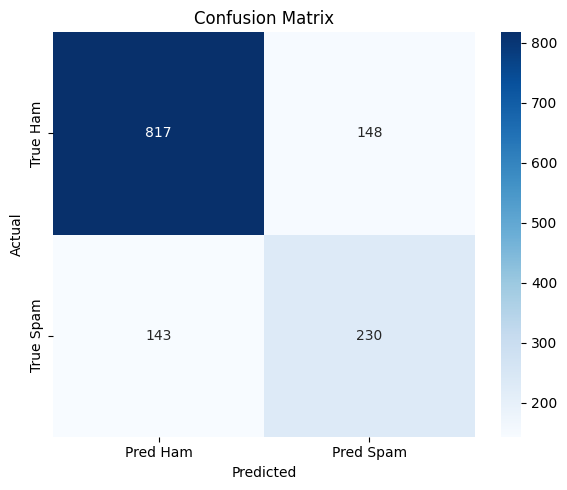

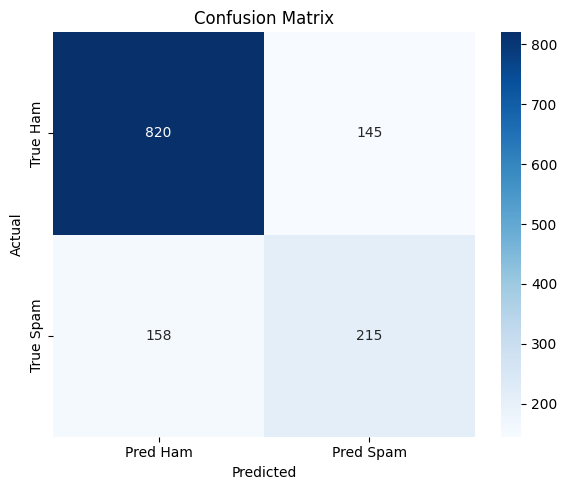

,precision,recall,f1,accuracy,pr_auc,train_runtime,prediction_runtime,ham_coverage,spam_coverage,mean_hits_spam,k
0,0.637066,0.442359,0.522152,0.774290,0.516271,48.232289,None,0.097409,0.442359,1.454545,20
1,0.619186,0.571046,0.594142,0.782511,0.573329,70.244664,None,0.135751,0.571046,1.877934,25
2,0.608466,0.616622,0.612517,0.782511,0.551703,236.842892,None,0.153368,0.616622,2.108696,30
3,0.597222,0.576408,0.586630,0.773543,0.567395,133.293786,None,0.150259,0.576408,2.102326,35


In [46]:
k_values = [20, 25, 30, 35]
linestyles = ["-", "--", ":", "-."]
colors_ham = ["#2D6CDF", "#1CA37A", "#A63EC5", "#008080"]
colors_spam = ["#E74C3C", "#E67E22", "#C0392B", "#B00020"]

pr_fig, pr_ax = create_pr_figure()
kde_fig, kde_ax = create_kde_figure(max_hits=6)

all_results = []

for k, ls, ch, cs in zip(k_values, linestyles, colors_ham, colors_spam):
    print(f"\n=== Running NSA for k={k} ===")

    nsa = VDetectorNSA_Binary(
        k=k,
        r_min=1, r_max=3,
        max_detectors=2000,
        max_tries=50000,
        sampling="antiprofile",
        random_state=42,
        batch_size=1000
    )

    nsa, train_time = nsa.fit(Xh_train_char_bin, return_runtime=True)

    y_pred, scores = nsa.predict(X_eval, k_hits=1, return_score=True)
    coverage = nsa.detector_coverage_report(X_eval, y_eval, k_hits=1)

    metrics = evaluate_model(
        y_true=y_eval,
        y_pred=y_pred,
        scores=scores,
        pr_ax=pr_ax,
        pr_label=f"k={k}",
        kde_ax=kde_ax,
        linestyle=ls,
        kde_color_ham=ch,
        kde_color_spam=cs,
        detector_coverage_report=coverage,
        train_runtime=train_time,
        max_hits_kde=6,    # <--- zoom
    )

    metrics["k"] = k
    all_results.append(metrics)

pr_ax.legend()
kde_ax.legend()

plt.show()

summary_df = pd.DataFrame(all_results)
summary_df

Char-level TF-IDF finally gives the NSA something to really work with.  As k gets higher, the detectors are better at finding character patterns that are specific to spam. This makes spam recall go up.  The bad news is that ham starts to get a few more false alarms, so the gain isn't free.  The sweet spot is around k ≈ 27–30, where F1 and PR-AUC are at their highest before the runtime and detector size get too big.

 The next limiting factor is not k anymore because this area is already working well.  The NSA just doesn't have enough detectors to cover the non-self space properly.  To push recall even further without changing the core behaviour, the next logical step is to add more detectors and give the model more coverage.


=== Running NSA with 3000 detectors ===
Generated 3000 detectors after 52363 tries in 65.58s.

=== Running NSA with 4000 detectors ===
Generated 3000 detectors after 52363 tries in 65.58s.

=== Running NSA with 4000 detectors ===
Generated 4000 detectors after 70327 tries in 87.91s.

=== Running NSA with 5000 detectors ===
Generated 4000 detectors after 70327 tries in 87.91s.

=== Running NSA with 5000 detectors ===
Generated 5000 detectors after 86827 tries in 107.88s.

=== Running NSA with 6000 detectors ===
Generated 5000 detectors after 86827 tries in 107.88s.

=== Running NSA with 6000 detectors ===
Generated 6000 detectors after 104887 tries in 129.66s.
Generated 6000 detectors after 104887 tries in 129.66s.


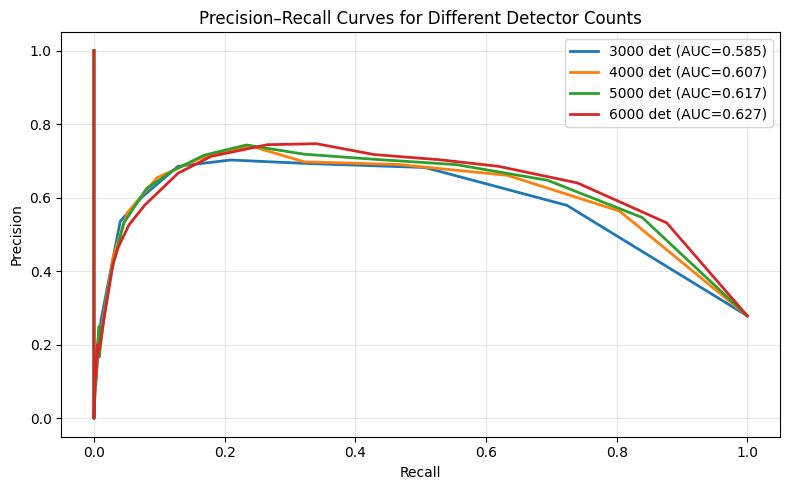

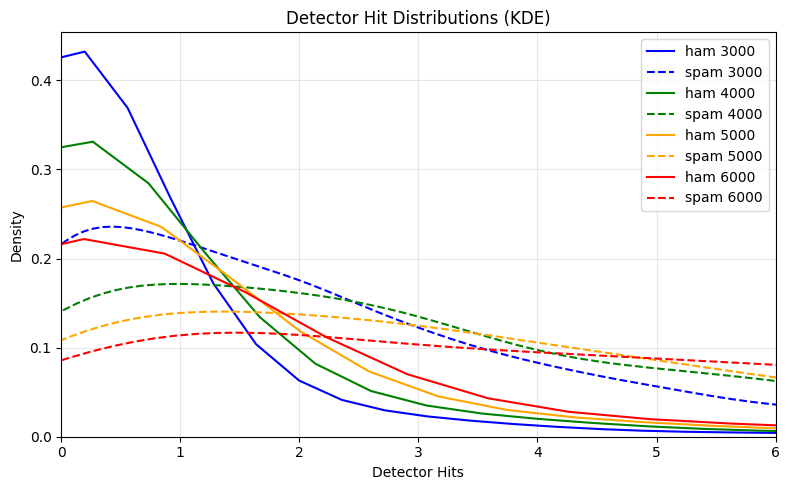

,detectors,precision,recall,f1,accuracy,pr_auc,train_runtime,prediction_runtime,ham_coverage,spam_coverage,mean_hits_spam
0,3000,0.579399,0.723861,0.643623,0.776532,0.585125,65.583776,0.026641,0.203109,0.723861,2.807407
1,4000,0.563910,0.804290,0.662983,0.772048,0.606601,87.911969,0.034999,0.240415,0.804290,3.543333
2,5000,0.546248,0.839142,0.661734,0.760837,0.617048,107.876514,0.043000,0.269430,0.839142,4.261981
3,6000,0.531707,0.876676,0.661943,0.750374,0.626620,129.660084,0.050691,0.298446,0.876676,5.006116


In [56]:
detector_counts = [3000, 4000, 5000, 6000]

results = []
pr_curves = []
hit_distributions = {}

for det_count in detector_counts:
    print(f"\n=== Running NSA with {det_count} detectors ===")

    nsa_big = VDetectorNSA_Binary(
        k=29,                # best-performing k
        r_min=1, r_max=3,
        max_detectors=det_count,
        max_tries=120000,
        sampling="antiprofile",
        random_state=42,
        batch_size=1500
    )

    # Train NSA
    nsa_big, train_runtime = nsa_big.fit(Xh_train_char_bin, return_runtime=True)

    # Predict
    pred_start = time.time()
    y_pred, scores = nsa_big.predict(X_eval, k_hits=1, return_score=True)
    prediction_runtime = time.time() - pred_start

    # Coverage metrics
    coverage_report = nsa_big.detector_coverage_report(X_eval, y_eval, k_hits=1)

    # Save hit distributions for KDE
    hit_distributions[det_count] = {
        "ham": scores[y_eval == 0],
        "spam": scores[y_eval == 1]
    }

    # Classification metrics
    precision_val = precision_score(y_eval, y_pred, pos_label=1, zero_division=0)
    recall_val    = recall_score(y_eval, y_pred, pos_label=1, zero_division=0)
    f1_val        = f1_score(y_eval, y_pred, pos_label=1)
    accuracy_val  = accuracy_score(y_eval, y_pred)

    # Correct PR-AUC computation
    precision_curve, recall_curve, _ = precision_recall_curve(y_eval, scores)
    pr_auc_val = auc(recall_curve, precision_curve)

    # Save metrics
    results.append({
        "detectors": det_count,
        "precision": precision_val,
        "recall": recall_val,
        "f1": f1_val,
        "accuracy": accuracy_val,
        "pr_auc": pr_auc_val,
        "train_runtime": train_runtime,
        "prediction_runtime": prediction_runtime,
        "ham_coverage": coverage_report["ham_coverage"],
        "spam_coverage": coverage_report["spam_coverage"],
        "mean_hits_spam": coverage_report["mean_hits_spam"],
    })

    # Save PR-curve for plotting
    pr_curves.append((det_count, precision_curve, recall_curve, pr_auc_val))

# =========================================================
# Plot all PR-curves on the same graph
# =========================================================
plt.figure(figsize=(8, 5))

for det_count, prec, rec, auc_val in pr_curves:
    plt.plot(rec, prec, linewidth=2, label=f"{det_count} det (AUC={auc_val:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for Different Detector Counts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# KDE Detector Hit Distributions (zoomed to useful range)
# =========================================================
plt.figure(figsize=(8, 5))

colors = ["blue", "green", "orange", "red"]

for (det_count, dist), col in zip(hit_distributions.items(), colors):
    sns.kdeplot(dist["ham"], fill=False, color=col, linestyle="-", label=f"ham {det_count}")
    sns.kdeplot(dist["spam"], fill=False, color=col, linestyle="--", label=f"spam {det_count}")

plt.xlim(0, 6)  # zoom where signal exists
plt.xlabel("Detector Hits")
plt.ylabel("Density")
plt.title("Detector Hit Distributions (KDE)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# Summary table
# =========================================================
summary_table = pd.DataFrame(results)
summary_table


Past ~3500 detectors, the algorithm:

• loses specificity
• saturates spam
• increases ham false alarms
• flattens in performance
• burns more runtime for no gain

4000 is the clear sweet spot because:

- It’s the highest F1

- It has lower runtime than 5000 or 6000

- It gives strong recall (0.8043) without completely sacrificing precision

and we will go with this setting and now we  will tune radius.


=== Testing R1_1_2 (r_min=1, r_max=2) ===
Generated 6 detectors after 120000 tries in 129.47s.

=== Testing R2_1_3 (r_min=1, r_max=3) ===
Generated 6 detectors after 120000 tries in 129.47s.

=== Testing R2_1_3 (r_min=1, r_max=3) ===
Generated 4000 detectors after 70327 tries in 87.55s.

=== Testing R3_2_2 (r_min=2, r_max=2) ===
Generated 4000 detectors after 70327 tries in 87.55s.

=== Testing R3_2_2 (r_min=2, r_max=2) ===
Generated 7 detectors after 120000 tries in 120.85s.

=== Testing R4_2_3 (r_min=2, r_max=3) ===
Generated 7 detectors after 120000 tries in 120.85s.

=== Testing R4_2_3 (r_min=2, r_max=3) ===
Generated 4000 detectors after 45589 tries in 57.87s.

=== Testing R5_3_3 (r_min=3, r_max=3) ===
Generated 4000 detectors after 45589 tries in 57.87s.

=== Testing R5_3_3 (r_min=3, r_max=3) ===
Generated 4000 detectors after 23249 tries in 28.58s.

=== Testing R6_3_4 (r_min=3, r_max=4) ===
Generated 4000 detectors after 23249 tries in 28.58s.

=== Testing R6_3_4 (r_min=3, r_ma

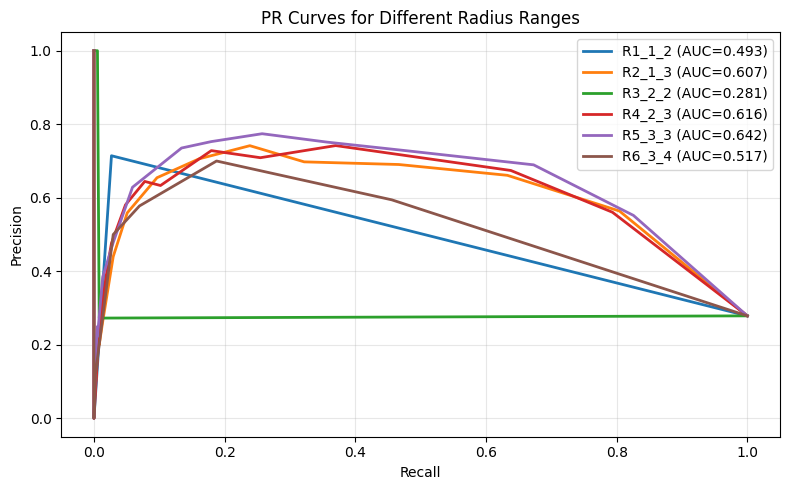

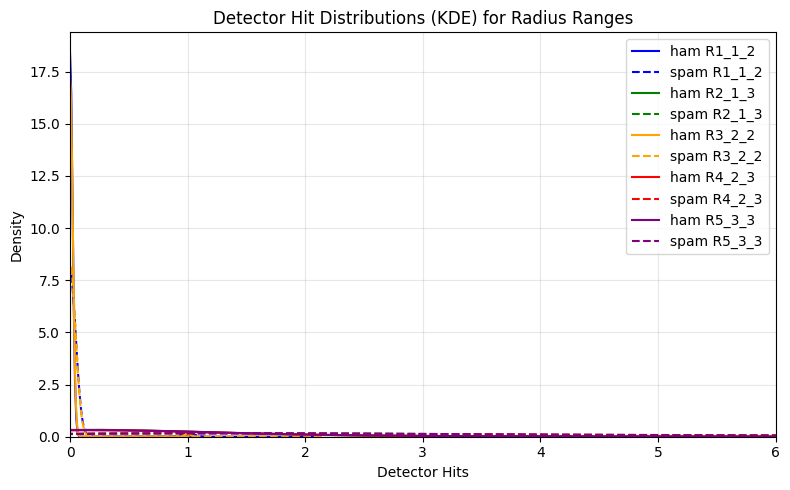

,config,r_min,r_max,precision,recall,f1,accuracy,pr_auc,train_runtime,prediction_runtime,ham_coverage,spam_coverage,mean_hits_spam
0,R1_1_2,1,2,0.714286,0.026810,0.051680,0.725710,0.492793,129.471455,0.001000,0.004145,0.026810,1.000000
1,R2_1_3,1,3,0.563910,0.804290,0.662983,0.772048,0.606601,87.554442,0.035010,0.240415,0.804290,3.543333
2,R3_2_2,2,2,0.272727,0.008043,0.015625,0.717489,0.280601,120.849441,0.001000,0.008290,0.008043,1.666667
3,R4_2_3,2,3,0.560606,0.793566,0.657048,0.769058,0.615604,57.872623,0.034240,0.240415,0.793566,3.814189
4,R5_3_3,3,3,0.551971,0.825737,0.661654,0.764574,0.641841,28.575218,0.034810,0.259067,0.825737,3.769481
5,R6_3_4,3,4,0.594406,0.455764,0.515933,0.761584,0.516726,13.883857,0.036199,0.120207,0.455764,1.641176


In [71]:
# ==========================================
# RADIUS CONFIGURATIONS TO TEST
# ==========================================
radius_configs = [
    ("R1_1_2",   1, 2),
    ("R2_1_3",   1, 3),
    ("R3_2_2",   2, 2),
    ("R4_2_3",   2, 3),
    ("R5_3_3",   3, 3),
    ("R6_3_4",   3, 4),
]

k = 29
det_count = 4000

results = []
pr_curves = []
hit_distributions = {}

# ==========================================
# MAIN SWEEP LOOP
# ==========================================
for name, r_min, r_max in radius_configs:
    print(f"\n=== Testing {name} (r_min={r_min}, r_max={r_max}) ===")

    nsa_r = VDetectorNSA_Binary(
        k=k,
        r_min=r_min,
        r_max=r_max,
        max_detectors=det_count,
        max_tries=120000,
        sampling="antiprofile",
        batch_size=1500,
        random_state=42
    )

    # Train
    nsa_r, train_runtime = nsa_r.fit(Xh_train_char_bin, return_runtime=True)

    # Predict
    pred_start = time.time()
    y_pred, scores = nsa_r.predict(X_eval, k_hits=1, return_score=True)
    prediction_runtime = time.time() - pred_start

    # Coverage
    coverage_report = nsa_r.detector_coverage_report(X_eval, y_eval, k_hits=1)

    # Store hit distributions (for KDE)
    hit_distributions[name] = {
        "ham": scores[y_eval == 0],
        "spam": scores[y_eval == 1]
    }

    # Standard metrics
    precision_val = precision_score(y_eval, y_pred, pos_label=1, zero_division=0)
    recall_val    = recall_score(y_eval, y_pred, pos_label=1, zero_division=0)
    f1_val        = f1_score(y_eval, y_pred, pos_label=1)
    accuracy_val  = accuracy_score(y_eval, y_pred)

    # PR-AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_eval, scores)
    pr_auc_val = auc(recall_curve, precision_curve)

    # Save row
    results.append({
        "config": name,
        "r_min": r_min,
        "r_max": r_max,
        "precision": precision_val,
        "recall": recall_val,
        "f1": f1_val,
        "accuracy": accuracy_val,
        "pr_auc": pr_auc_val,
        "train_runtime": train_runtime,
        "prediction_runtime": prediction_runtime,
        "ham_coverage": coverage_report["ham_coverage"],
        "spam_coverage": coverage_report["spam_coverage"],
        "mean_hits_spam": coverage_report["mean_hits_spam"],
    })

    # Save PR curve
    pr_curves.append((name, precision_curve, recall_curve, pr_auc_val))

# ==========================================
# PLOT ALL PRECISION–RECALL CURVES
# ==========================================
plt.figure(figsize=(8, 5))
for name, prec, rec, auc_val in pr_curves:
    plt.plot(rec, prec, linewidth=2, label=f"{name} (AUC={auc_val:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curves for Different Radius Ranges")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================
# PLOT KDE HIT DISTRIBUTIONS
# ==========================================
plt.figure(figsize=(8, 5))

colors = ["blue", "green", "orange", "red", "purple"]

for (name, dist), col in zip(hit_distributions.items(), colors):
    sns.kdeplot(dist["ham"], fill=False, color=col, linestyle="-",  label=f"ham {name}")
    sns.kdeplot(dist["spam"], fill=False, color=col, linestyle="--", label=f"spam {name}")

plt.xlim(0, 6)
plt.xlabel("Detector Hits")
plt.ylabel("Density")
plt.title("Detector Hit Distributions (KDE) for Radius Ranges")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================
# SUMMARY TABLE
# ==========================================
summary_table = pd.DataFrame(results)
summary_table


r_min 1 and r_max 3 seems to give the best results so we will go with that setting.
next we will test with k_hits to see if we can improve precision or recall further.

Generated 4000 detectors after 70327 tries in 88.67s.

=== Running NSA with k_hits=1 ===
              precision    recall  f1-score   support

         ham       0.91      0.76      0.83       965
        spam       0.56      0.80      0.66       373

    accuracy                           0.77      1338
   macro avg       0.74      0.78      0.75      1338
weighted avg       0.81      0.77      0.78      1338


=== Running NSA with k_hits=2 ===
              precision    recall  f1-score   support

         ham       0.86      0.87      0.87       965
        spam       0.66      0.63      0.65       373

    accuracy                           0.81      1338
   macro avg       0.76      0.75      0.76      1338
weighted avg       0.80      0.81      0.81      1338


=== Running NSA with k_hits=3 ===
              precision    recall  f1-score   support

         ham       0.82      0.92      0.86       965
        spam       0.69      0.47      0.56       373

    accuracy           

,precision,recall,f1,accuracy,pr_auc,train_runtime,prediction_runtime,ham_coverage,spam_coverage,mean_hits_spam,k_hits
0,0.563910,0.804290,0.662983,0.772048,0.606601,88.671961,0.033901,0.240415,0.80429,3.543333,1
1,0.661064,0.632708,0.646575,0.807175,0.606601,88.671961,0.036642,0.240415,0.80429,3.543333,2
2,0.690476,0.466488,0.556800,0.792975,0.606601,88.671961,0.038060,0.240415,0.80429,3.543333,3
3,0.697674,0.321716,0.440367,0.772048,0.606601,88.671961,0.038080,0.240415,0.80429,3.543333,4


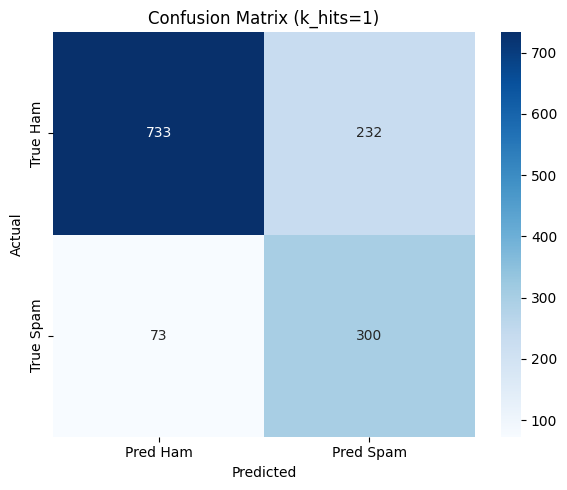

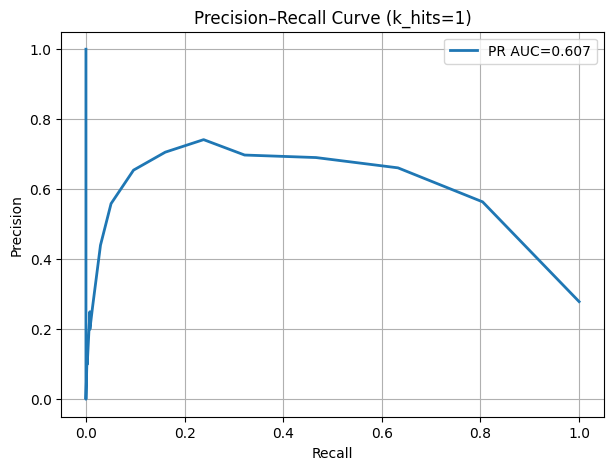

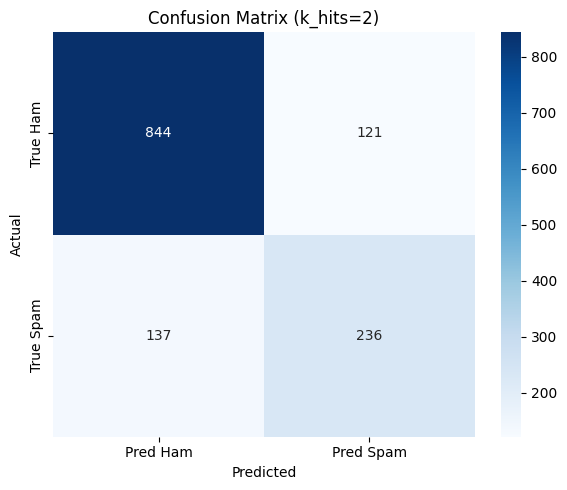

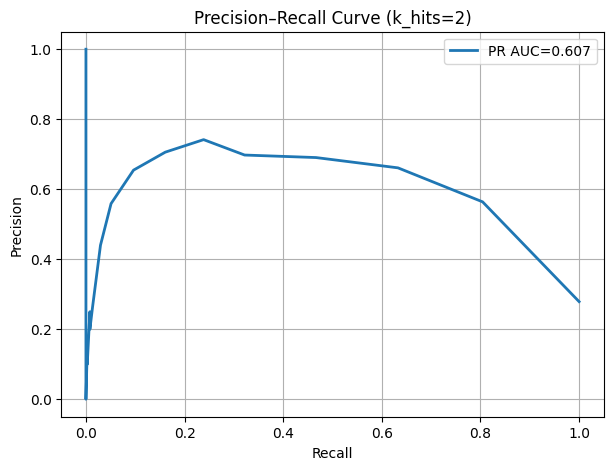

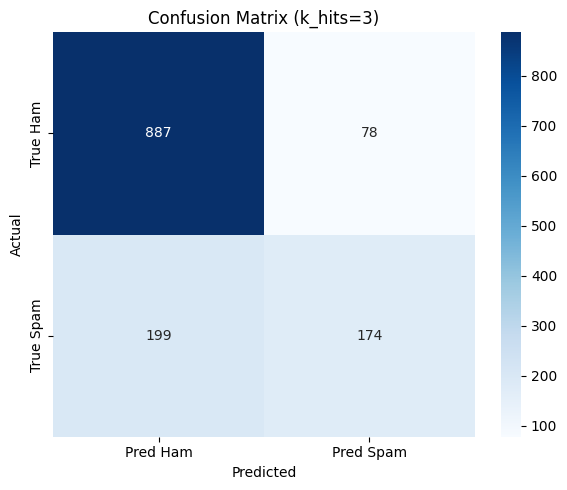

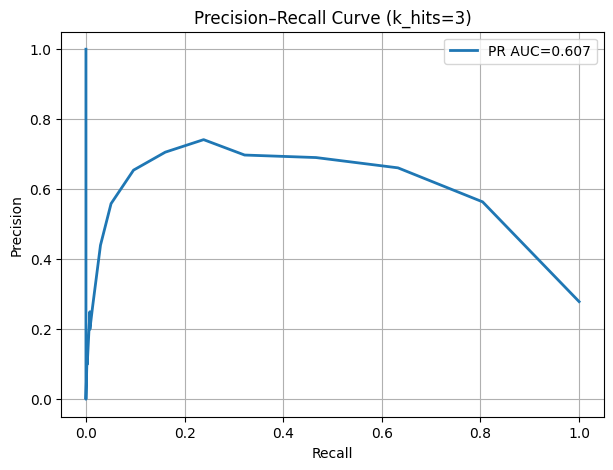

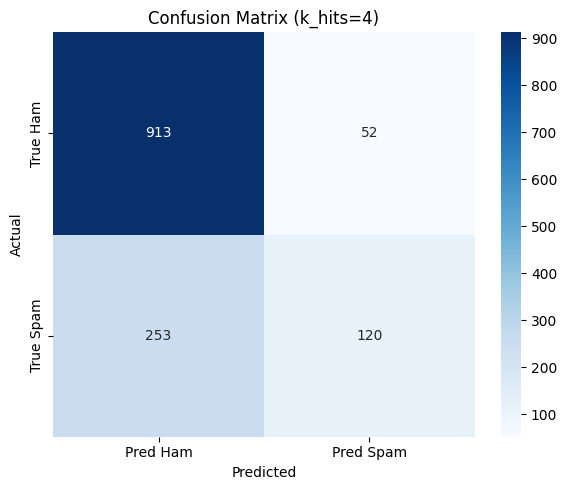

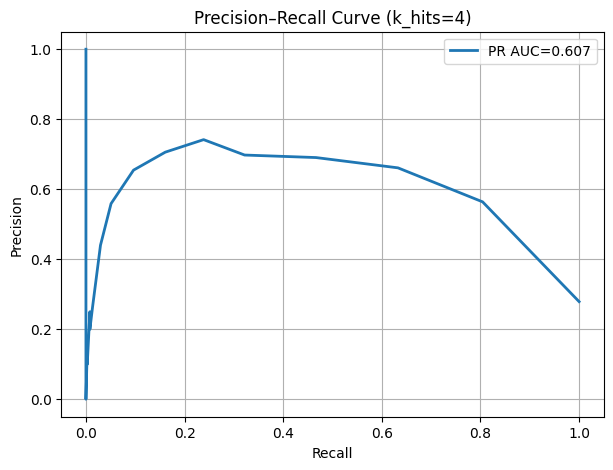

In [74]:
# ============================================================
# FINAL k_hits SWEEP
# With plots & full evaluation
# ============================================================

k_hits_values = [1, 2, 3, 4]

results = []
pr_curves = []
hit_distributions = {}

# Train model once
nsa_model = VDetectorNSA_Binary(
    k=29,
    r_min=1, 
    r_max=3,
    max_detectors=4000,
    max_tries=120000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1500
)

nsa_model, train_runtime = nsa_model.fit(Xh_train_char_bin, return_runtime=True)

for kh in k_hits_values:
    print(f"\n=== Running NSA with k_hits={kh} ===")

    # Predict
    pred_start = time.time()
    y_pred, scores = nsa_model.predict(X_eval, k_hits=kh, return_score=True)
    prediction_runtime = time.time() - pred_start

    # Coverage
    coverage = nsa_model.detector_coverage_report(X_eval, y_eval, k_hits=kh)

    # Save hit distribution
    hit_distributions[kh] = {
        "ham": scores[y_eval == 0],
        "spam": scores[y_eval == 1]
    }

    # ===== FULL EVALUATION (prints confusion matrix, report, PR + histogram) =====
    eval_summary = evaluate_model(
        y_true=y_eval,
        y_pred=y_pred,
        scores=scores,
        target_names=("ham","spam"),
        cm_title=f"Confusion Matrix (k_hits={kh})",
        pr_title=f"Precision–Recall Curve (k_hits={kh})",
        detector_coverage_report=coverage,
        train_runtime=train_runtime,
        prediction_runtime=prediction_runtime
    )
    # ==============================================================================

    eval_summary["k_hits"] = kh
    results.append(eval_summary)

    # Save PR curve data
    precision_curve, recall_curve, _ = precision_recall_curve(y_eval, scores)
    pr_auc_val = auc(recall_curve, precision_curve)
    pr_curves.append((kh, precision_curve, recall_curve, pr_auc_val))


# ============================================================
# SUMMARY TABLE
# ============================================================
summary_khits = pd.DataFrame(results)
summary_khits


k_hits = 2 is the sweet spot.
It gives you:

- the highest accuracy,

- best precision–recall trade-off,

- and no catastrophic recall collapse.


This is the final threshold you should use for your test-set evaluation.

<a class="anchor" id="evaluate"></a>
# Evaluate

Now we will evaluate the final model on the test set using the best hyperparameters found during validation.

Final test matrix: (1339, 16688)
Generated 5000 detectors after 86827 tries in 104.23s.
Training runtime (final model): 104.23 seconds
Prediction runtime (final model): 0.0532 seconds
Generated 5000 detectors after 86827 tries in 104.23s.
Training runtime (final model): 104.23 seconds
Prediction runtime (final model): 0.0532 seconds


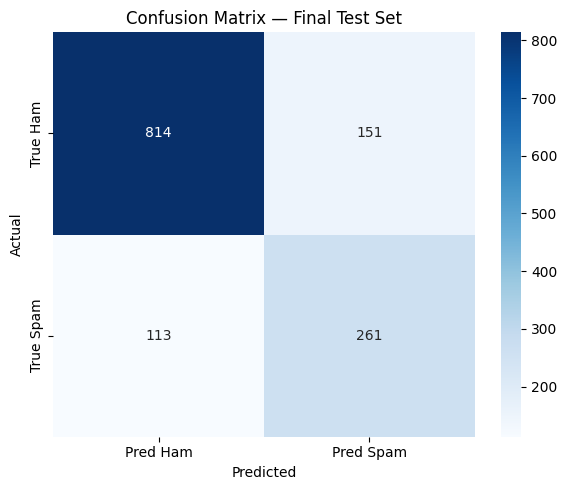

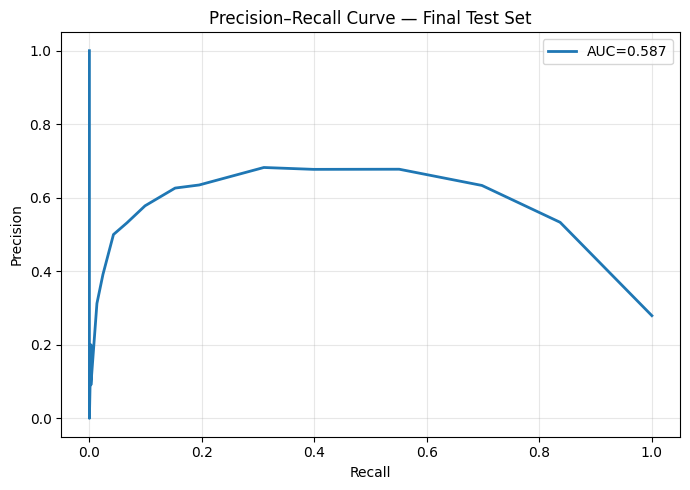

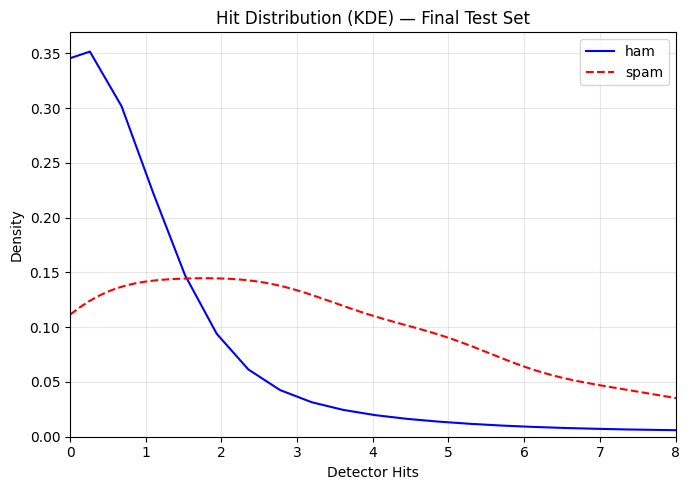

,precision,recall,f1,accuracy,pr_auc,train_runtime,prediction_runtime,ham_coverage,spam_coverage,mean_hits_spam
0,0.633495,0.697861,0.664122,0.802838,0.586663,104.227633,0.053155,0.283938,0.836898,4.070288


In [75]:
# ============================================================
# FINAL TEST-SET EVALUATION (FULL PLOTS)
# ============================================================

# Build test matrix
X_test_final = sp.vstack([Xh_test_char_bin, Xs_test_char_bin])
y_test_final = np.hstack([
    np.zeros(Xh_test_char_bin.shape[0], dtype=np.uint8),
    np.ones(Xs_test_char_bin.shape[0], dtype=np.uint8)
])

print("Final test matrix:", X_test_final.shape)

# ============================================================
# Train final model
# ============================================================

nsa_char_final = VDetectorNSA_Binary(
    k=29,
    r_min=1, r_max=3,
    max_detectors=5000,
    max_tries=100000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
)

nsa_char_final, train_runtime_final = nsa_char_final.fit(Xh_train_char_bin, return_runtime=True)
print(f"Training runtime (final model): {train_runtime_final:.2f} seconds")

# ============================================================
# Prediction
# ============================================================

pred_start = time.time()
y_pred_final, scores_final = nsa_char_final.predict(X_test_final, k_hits=2, return_score=True)
prediction_runtime_final = time.time() - pred_start
print(f"Prediction runtime (final model): {prediction_runtime_final:.4f} seconds")

# ============================================================
# Coverage
# ============================================================

coverage_final = nsa_char_final.detector_coverage_report(X_test_final, y_test_final, k_hits=1)

# ============================================================
# Confusion Matrix
# ============================================================

plot_confusion_matrix_heatmap(
    y_test_final,
    y_pred_final,
    labels=("ham", "spam"),
    title="Confusion Matrix — Final Test Set"
)
plt.show()

# ============================================================
# Precision–Recall Curve
# ============================================================

precision_curve, recall_curve, _ = precision_recall_curve(y_test_final, scores_final)
pr_auc_val = auc(recall_curve, precision_curve)

plt.figure(figsize=(7,5))
plt.plot(recall_curve, precision_curve, linewidth=2, label=f"AUC={pr_auc_val:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Final Test Set")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# ============================================================
# KDE Hit Distributions (ham vs spam)
# ============================================================

plt.figure(figsize=(7,5))
sns.kdeplot(scores_final[y_test_final == 0], fill=False, color="blue", linestyle="-", label="ham")
sns.kdeplot(scores_final[y_test_final == 1], fill=False, color="red", linestyle="--", label="spam")
plt.xlim(0, 8)
plt.xlabel("Detector Hits")
plt.ylabel("Density")
plt.title("Hit Distribution (KDE) — Final Test Set")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Combined summary
# ============================================================

eval_results_final = {
    "precision": precision_score(y_test_final, y_pred_final, pos_label=1, zero_division=0),
    "recall": recall_score(y_test_final, y_pred_final, pos_label=1, zero_division=0),
    "f1": f1_score(y_test_final, y_pred_final, pos_label=1),
    "accuracy": accuracy_score(y_test_final, y_pred_final),
    "pr_auc": pr_auc_val,
    "train_runtime": train_runtime_final,
    "prediction_runtime": prediction_runtime_final,
    "ham_coverage": coverage_final["ham_coverage"],
    "spam_coverage": coverage_final["spam_coverage"],
    "mean_hits_spam": coverage_final["mean_hits_spam"],
}

summary_table_final = pd.DataFrame([eval_results_final])
summary_table_final
